

# 项目：调查数据集（哪些因素会影响患者按照其挂号预约前往医院就诊？）

## 目录
<ul>
<li><a href="#intro">简介</a></li>
<li><a href="#wrangling">数据整理</a></li>
<li><a href="#eda">探索性数据分析</a></li>
<li><a href="#conclusions">结论</a></li>
</ul>

<a id='intro'></a>
## 简介

本数据集包含10万条巴西预约挂号的求诊信息，研究病人是否如约前往医院就诊。每行数据录入了有关患者特点的多个数值，如以下列表所示：

| ** 因素 ** | ** 说明** |
|----------------------|-------------------| 
| PatientId  | 患者的ID |
| AppointmentID   | 预约号 |
| Gender |性别   |
| ScheduledDay | 预约日期 |
| AppointmentDay |就诊日期 |
|Age  | 年龄 |
| Neighbourhood |街区|
|Scholarship |福利保障，1为是，0为否|
|Hipertension |高血压，1为是，0为否|
|Diabetes |糖尿病，1为是，0为否|
|Alcoholism|酗酒，1为是，0为否|
|Handcap | 残疾，1为是，0为否|
|SMS_received |收否收到提醒短信，1为是，0为否|
|No-show | 是否按约就诊？No为按时就诊，Yes为没有按时就诊|


笔者主观推测病人的年龄、预约时间和是否是保障人群这三个因素会对患者是否按挂号就诊产生影响。为了验证这个推测，这份报告将着重对这三个因素进行分析，以验证推测。

分析步骤分为以下几步：
* 导入数据
* 数据整理/清理
* 数据分析
    * 年龄对是否按时就诊的影响
    * 预定时间和就诊时间的差值对是否按时就诊的影响
    * 是否有福利保障对是否按时就诊对影响
* 结论


## 一、导入数据

In [200]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

<a id='wrangling'></a>
## 二、数据整理
> 先清理'noshowappointments-kagglev2-may-2016.csv'的数据，去重，去nan，去掉不需要的数据。

In [201]:
# 加载数据并打印几行。进行这几项操作，来检查数据类型，以及是否有缺失数据或错误数据的情况。
df = pd.read_csv ('noshowappointments-kagglev2-may-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [202]:
df.isnull().sum() #是否有数据缺失

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

In [203]:
df.duplicated().sum() #是否有数据重复

0

In [204]:
df.info() #看各列数据类型

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


### b.数据清理
> 改变数据名字，改变不合理的数据类型，并把数据分为Noshow和Showup两组

In [205]:
df.rename(columns = lambda x: x.lower(),inplace=True) #把列名变小写，统一格式
df.head(2)

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No


In [206]:
df.patientid = df.patientid.astype(int) #改变不合理的数据类型
df.scheduledday=pd.to_datetime(df.scheduledday)
df.appointmentday = pd.to_datetime(df.appointmentday)

In [207]:
df.head(2)

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no-show
0,29872499824296,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No


In [208]:
df.rename(columns = {"no-show":"noshow"},inplace=True)

In [209]:
df.noshow.value_counts() #看按时就诊的人数和取消人数

No     88208
Yes    22319
Name: noshow, dtype: int64

> 把按时就诊和数据和取消的数据分开，取消的数据命名为df_noshow，按时就诊的数据为df_showup，形成对照组。

In [210]:
df_noshow = df.query('noshow =="Yes"')
df_noshow.drop('noshow', axis=1, inplace=True)
df_noshow.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received
6,733688164476661,5630279,F,2016-04-27 15:05:12,2016-04-29,23,GOIABEIRAS,0,0,0,0,0,0
7,3449833394123,5630575,F,2016-04-27 15:39:58,2016-04-29,39,GOIABEIRAS,0,0,0,0,0,0
11,7542951368435,5620163,M,2016-04-26 08:44:12,2016-04-29,29,NOVA PALESTINA,0,0,0,0,0,1
17,14794966191172,5633460,F,2016-04-28 09:28:57,2016-04-29,40,CONQUISTA,1,0,0,0,0,0
20,622257462899397,5626083,F,2016-04-27 07:51:14,2016-04-29,30,NOVA PALESTINA,0,0,0,0,0,0


In [211]:
df_showup = df.query('noshow =="No"')
df_showup.drop('noshow', axis=1, inplace=True)
df_showup.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received
0,29872499824296,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0
1,558997776694438,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0
2,4262962299951,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0
3,867951213174,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0
4,8841186448183,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0


<a id='eda'></a>
## 三、探索性数据分析



### 研究问题 1（患者是否就诊和年龄有关系吗？ ）

In [212]:
df.age.describe() #查看所有年龄信息

count    110527.000000
mean         37.088874
std          23.110205
min          -1.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: age, dtype: float64

从以上年龄的分析来看年龄跨度比较大，按百度百科的年龄划分来给年龄分类，一共分为六个年龄层次

In [213]:
bin_edges = [0,6,12,17,45,69,120] # age groups from https://baike.baidu.com/item/%E6%96%B0%E5%B9%B4%E9%BE%84%E5%88%86%E6%AE%B5/4231762?fr=aladdin
bin_names = ['infant','child','teenager','youngster','middle_aged','olderly']
df['age_group'] = pd.cut(df['age'], bin_edges, labels = bin_names)
df.head()

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,noshow,age_group
0,29872499824296,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,middle_aged
1,558997776694438,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,middle_aged
2,4262962299951,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,middle_aged
3,867951213174,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,child
4,8841186448183,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,middle_aged


In [214]:
show_counts = df.groupby(['noshow','age_group']).count().age
show_counts

noshow  age_group  
No      infant          7851
        child           5978
        teenager        4653
        youngster      31021
        middle_aged    27959
        olderly         7845
Yes     infant          1862
        child           1806
        teenager        1690
        youngster       9185
        middle_aged     5685
        olderly         1452
Name: age, dtype: int64

In [215]:
show_total = df.groupby('noshow').count().age
show_total

noshow
No     88208
Yes    22319
Name: age, dtype: int64

In [216]:
showup_propotions = show_counts.No/show_total.No
showup_propotions

age_group
infant         0.089006
child          0.067772
teenager       0.052750
youngster      0.351680
middle_aged    0.316967
olderly        0.088938
Name: age, dtype: float64

In [217]:
noshow_propotions = show_counts.Yes/show_total.Yes
noshow_propotions

age_group
infant         0.083427
child          0.080918
teenager       0.075720
youngster      0.411533
middle_aged    0.254716
olderly        0.065057
Name: age, dtype: float64

In [218]:
ind = np.arange(len(showup_propotion))
width = 0.4 #条柱宽度

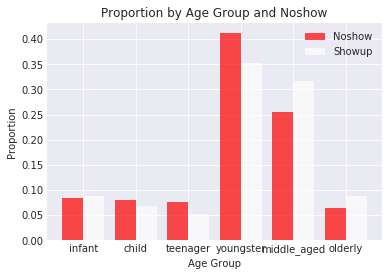

In [219]:
red_bars = plt.bar(ind, noshow_propotions, width, color='r', alpha=.7, label='Noshow')
white_bars = plt.bar(ind + width, showup_propotions, width, color='w', alpha=.7, label='Showup')

# 标题和标签
plt.ylabel('Proportion')
plt.xlabel('Age Group')
plt.title('Proportion by Age Group and Noshow')
locations = ind + width / 2  # x 坐标刻度位置
labels = bin_names  # x 坐标刻度标签
plt.xticks(locations, labels)

# 图例
plt.legend()

**结论一** ： 从年龄结构来看，青年人（18-45岁）和中年人（46-69岁）的病人居多。青年人取消就诊的人数最多，占取消就诊总人数的41%，并且比按时就诊的青年人比例多出6%。中年人取消就诊的人数比例为占取消就诊总人数的25.5%，比按时就诊的中年人比例少6%。年龄结构对是否就诊有一定影响，青年人取消就诊最多，其次为中年人。

### 研究问题 2（Noshow和预定时间&就诊时间之间的时间长短有关吗？）

In [220]:
df['time_diff'] = df.appointmentday - df.scheduledday #找出预约时间和就诊时间的时间差
df.head()

,patientid,appointmentid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,noshow,age_group,time_diff
0,29872499824296,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,middle_aged,-1 days +05:21:52
1,558997776694438,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,middle_aged,-1 days +07:51:33
2,4262962299951,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,middle_aged,-1 days +07:40:56
3,867951213174,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,child,-1 days +06:30:29
4,8841186448183,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,middle_aged,-1 days +07:52:37


In [221]:
df.groupby('noshow').time_diff.describe()

,count,mean,std,min,25%,50%,75%,max
noshow,,,,,,,,
No,88208,8 days 06:56:46.224594,14 days 12:57:11.876227,-1 days +03:15:06,-1 days +14:59:00.250000,1 days 14:56:44,11 days 15:25:55,178 days 13:17:18
Yes,22319,15 days 08:17:34.998879,16 days 14:24:19.715831,-7 days +10:10:40,3 days 10:47:25,10 days 07:42:31,22 days 15:44:33,178 days 13:19:01


**结论二** 从预定时间和就诊时间的时间差来看，大部分就诊病人的预定时间较短，平均提前8天预定，而取消预定的病人预定时间较长，平均提前了15天预定。结论为：越早预定，取消的概率越高。

### 研究问题 3（Noshow和Scholorship有关吗？）

In [222]:
scholarship_counts = df.groupby(['noshow','scholarship']).count().age
scholarship_counts

noshow  scholarship
No      0              79925
        1               8283
Yes     0              19741
        1               2578
Name: age, dtype: int64

In [223]:
df_noshow = scholarship_counts.Yes/show_total.Yes
df_noshow

scholarship
0    0.884493
1    0.115507
Name: age, dtype: float64

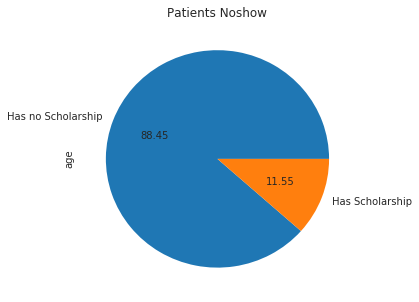

In [224]:
df_noshow.plot.pie(labels = ['Has no Scholarship','Has Scholarship'],autopct='%.2f',title = 'Patients Noshow',figsize=(5,5))

In [225]:
df_showup = scholarship_counts.No/show_total.No
df_showup

scholarship
0    0.906097
1    0.093903
Name: age, dtype: float64

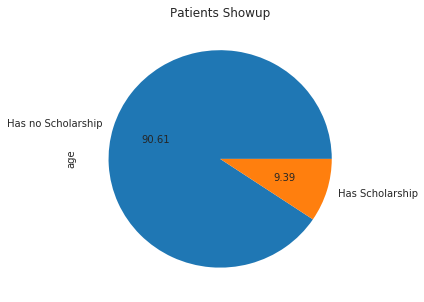

In [226]:
df_showup.plot.pie(labels = ['Has no Scholarship','Has Scholarship'],autopct='%.2f',title = 'Patients Showup', figsize=(5,5))

**结论三** 取消预约的患者所拥有福利保障的比例比按时就诊的多。从这点来看，是不是拥有福利项目对是否按时就诊没有明显影响。

<a id='conclusions'></a>
## 结论

在未前往就诊的挂号预约这个案例中，我们分析了三个因素对病人是否按照预约就诊产生的影响。
一、从年龄的角度看，我们把年龄根据百科分类分为婴儿、儿童、青少年、青年人、中年人和老年人这六类。其中青年人取消预约的比例最高，在所有取消的人数中达到41%，其次是中年人，另外四类偏少。
二、预定时间对是否就诊的影响也很大。大部分就诊病人的预定时间较短，平均提前8天预定，而取消预定的病人预定时间较长，平均提前了15天预定。越早预定，取消的概率越高。
三、拥有福利保障对是否按预约就诊没有明显影响。

这个研究仅仅分析了其中三个因素，并没有对所有因素进行分析。并且对各个因素之间对关系也没有进行研究，因此具有局限性。



In [227]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

255